In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

2025-02-13 13:43:03.808992: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 13:43:03.810452: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 13:43:03.813576: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 13:43:03.824197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739454183.841514   21347 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739454183.84

In [ ]:
from data_loading import OxfordPetDataset, view_image, resize_normalize
from augmentation import random_flip, get_augmentation_layers

# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()

train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name

#view_image(train, ds_info, get_label_name)

# Resize and normalize
img_size = (128, 128)

#do train = train.map(resize_normalize) using lambda function
#train = train.map(lambda image, label: resize_normalize(image, img_size))

print("\n")

for image, label in train.take(1):
    plt.imshow(image)
    print("Label shape:", label.shape)
    print("Label values:", label.numpy())  # Optional: To see the one-hot encoded values

Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669




ValueError: too many values to unpack (expected 3)

In [ ]:
data_augmentation = get_augmentation_layers()

2025-02-13 13:20:09.612657: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


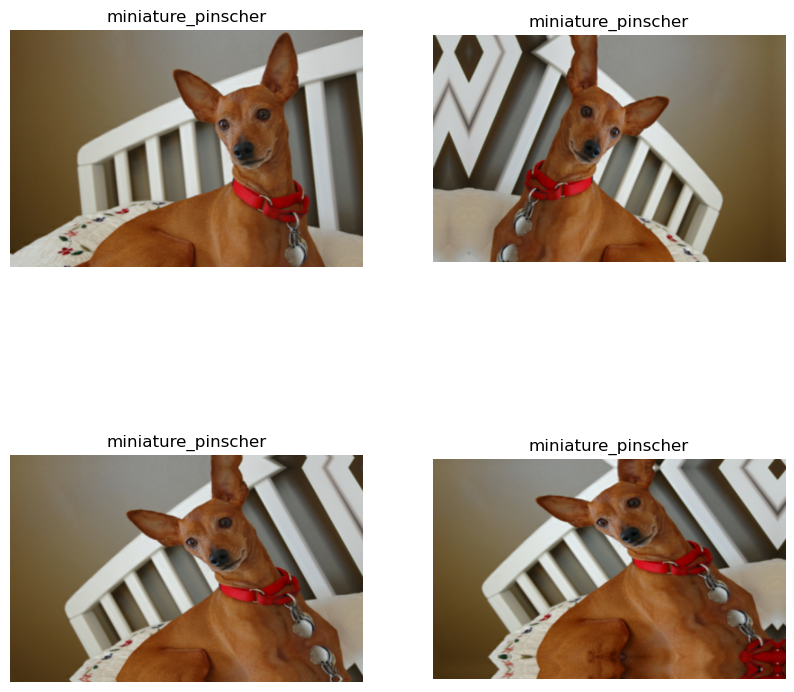

In [ ]:
for image, label in train.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(get_label_name(int(label)))
        plt.axis("off")

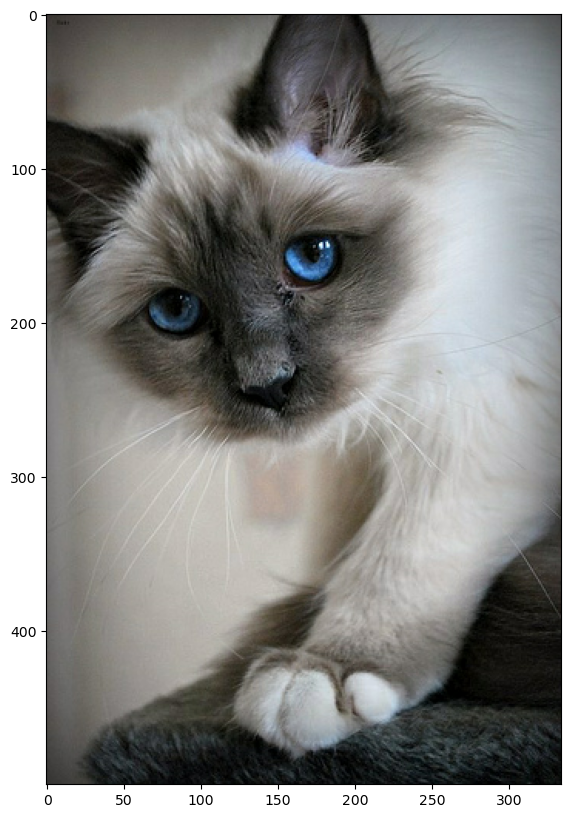

In [ ]:
for image, label in train.take(1):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

In [ ]:
BATCH_SIZE = 32

# Batch the data and use prefetching to optimize loading speed
# AVOID use of caching (Google Colab RAM limits)

train_ds = train.batch(batch_size=BATCH_SIZE, 
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val.batch(batch_size=BATCH_SIZE, 
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)
                      
test_ds = test.batch(batch_size=BATCH_SIZE, 
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)